# Pairwise Mismatch

L'objectif de ce notebook est d'effectuer une évaluation de nos modèles en utilisant la technique de Pairwise Mismatch décrite dans le papier de référence. (*<../../pdf/1 Original Paper.pdf>*).

## Description de la métrique
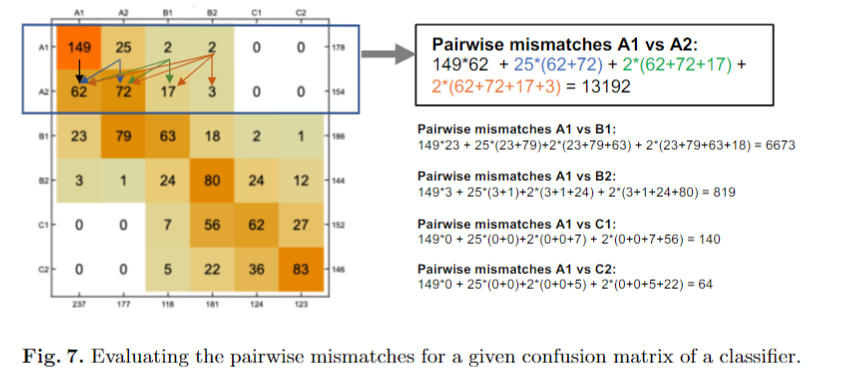
## Résultats que l'on cherche à reproduire
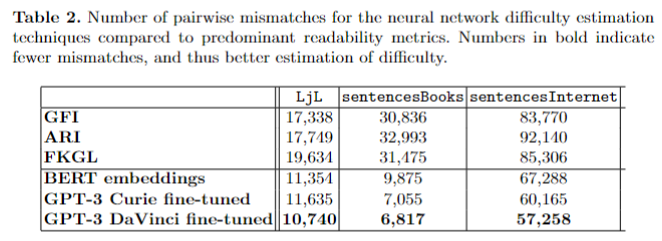

In [1]:
# ---------------------------- PREPARING NOTEBOOK ---------------------------- #
# Autoreload
%load_ext autoreload
%autoreload 2

# Random seed
import numpy as np
np.random.seed(42)

# External modules
import os
from IPython.display import display, Markdown, Latex, clear_output
from tqdm import notebook as tqdm

# Set global log level
import logging
logging.basicConfig(level=logging.INFO)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Define PWD as the current git repository
import git
repo = git.Repo('.', search_parent_directories=True)
pwd = repo.working_dir
os.chdir(pwd)

## Création de la fonction d'évaluation

Nous devons dans un premier temps créer une fonction capable de nous donner les scores de **PairWise Missmatch** en fonction des prédictions faites par chaque modèle.

In [2]:
# ------------------ PAIRWISE MISSMATCH FUNCTION DEFINITION ------------------ #
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


def pairwise_mismatch(y_pred: pd.Series, y_real: pd.Series) -> np.array:
    predictions = pd.DataFrame({"pred": y_pred, "real": y_real})

    # Sort alphabetically
    predictions = predictions.sort_values(by=["real", "pred"])

    # Transform labels to integers while conserving the alphabetical order
    predictions["pred"] = predictions["pred"].astype("category")
    predictions["real"] = predictions["real"].astype("category")

    # Initialisez le LabelEncoder
    label_encoder = LabelEncoder()

    # Encodez les labels
    unique_labels = pd.unique(predictions[["pred", "real"]].values.ravel("K"))
    label_encoder.fit(unique_labels)
    predictions["pred"] = label_encoder.transform(predictions["pred"])
    predictions["real"] = label_encoder.transform(predictions["real"])

    # Compute the pairwise mismatch
    mismatch = (
        predictions["pred"].expanding().apply(lambda s: (s.iloc[-1] - s < 0).sum())
        + predictions["pred"][::-1]
        .expanding()
        .apply(lambda s: (s.iloc[-1] - s > 0).sum())[::-1]
    )

    return mismatch.mean()


pairwise_mismatch(
    pd.Series(["1", "3", "2", "3", "2", "3"]), pd.Series(["1", "1", "2", "2", "3", "3"])
)

1.0

## Evaluation des evaluateurs de Lisibilité

Maintenant, nous allons devoir coder les index de lisibilité étudiés dans l'article :
- **GFI**
- **ARI**
- **FKGL**

Pour pouvoir comparer les résultats de ces modèles avec les labels CEFR, nous allons appliquer une simple regression linéaire sur les labels CEFR et les scores de lisibilité.

In [3]:
# ------------------------- DEFFINE READABILITY INDEX ------------------------ #

import textstat
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.preprocessing import LabelEncoder


class TextStat(BaseEstimator, TransformerMixin):
    def __init__(self, model_name: str):
        """
        Args:
            model_name (str): Name of the model to use. Can be one of:
                - GFI
                - ARI
                - FKGL
        """
        if model_name == "GFI":
            self.textstat_model = textstat.gunning_fog
        elif model_name == "ARI":
            self.textstat_model = textstat.automated_readability_index
        elif model_name == "FKGL":
            self.textstat_model = textstat.flesch_kincaid_grade
        else:
            raise ValueError("Model name must be one of: GFI, ARI, FKGL")

        self.logistic_regression = LogisticRegression()
        self.label_encoder = LabelEncoder()

    def fit(self, X, y=None):
        predictions = np.array([self.textstat_model(x) for x in X]).reshape(-1, 1)
        y = self.label_encoder.fit_transform(y)
        self.logistic_regression.fit(predictions, y)
        return self

    def predict(self, X):
        predictions = np.array([self.textstat_model(x) for x in X]).reshape(-1, 1)
        y = self.logistic_regression.predict(predictions)
        return self.label_encoder.inverse_transform(y)


gfi_model = TextStat("GFI")
ari_model = TextStat("ARI")
fkgl_model = TextStat("FKGL")

In [4]:
# --------------------------- LOAD AND PREPARE DATA -------------------------- #
import os
import pandas as pd

csv_list = {}
for file in os.listdir(os.path.join(pwd, "data", "raw", "difficulty_estimation")):
    if file.endswith(".csv"):
        file_key = [
            "_".join(os.path.splitext(file)[0].split("_")[:-1]),
            os.path.splitext(file)[0].split("_")[-1],
        ]
        if file_key[0] not in csv_list:
            csv_list[file_key[0]] = {}
        csv_list[file_key[0]][file_key[1]] = pd.read_csv(
            os.path.join(pwd, "data", "raw", "difficulty_estimation", file)
        )

In [5]:
# ----------------------------- TRAIN AND PREDICT ---------------------------- #

for df in csv_list:
    # Train models
    gfi_model.fit(
        csv_list[df]["train"]["sentence"], csv_list[df]["train"]["difficulty"]
    )
    ari_model.fit(
        csv_list[df]["train"]["sentence"], csv_list[df]["train"]["difficulty"]
    )
    fkgl_model.fit(
        csv_list[df]["train"]["sentence"], csv_list[df]["train"]["difficulty"]
    )

    # Predict on test set
    csv_list[df]["gfi"] = gfi_model.predict(csv_list[df]["test"]["sentence"])
    csv_list[df]["ari"] = ari_model.predict(csv_list[df]["test"]["sentence"])
    csv_list[df]["fkgl"] = fkgl_model.predict(csv_list[df]["test"]["sentence"])

In [6]:
# ------------------------- COMPUTE READABILITY INDEX ------------------------ #

for df in csv_list:
    # Compute pairwise mismatch
    csv_list[df]["gfi_pairwise_mismatch"] = pairwise_mismatch(
        csv_list[df]["gfi"], csv_list[df]["test"]["difficulty"]
    ).sum()
    csv_list[df]["ari_pairwise_mismatch"] = pairwise_mismatch(
        csv_list[df]["ari"], csv_list[df]["test"]["difficulty"]
    ).sum()
    csv_list[df]["fkgl_pairwise_mismatch"] = pairwise_mismatch(
        csv_list[df]["fkgl"], csv_list[df]["test"]["difficulty"]
    ).sum()

# ------------------------- DISLAY PAIRWISE MISMATCH ------------------------- #
df = pd.DataFrame(
    [
        csv_list[df][pairwise]
        for df in csv_list
        for pairwise in [
            "gfi_pairwise_mismatch",
            "ari_pairwise_mismatch",
            "fkgl_pairwise_mismatch",
        ]
    ],
    index=[
        f"{df}_{pairwise}_test"
        for df in csv_list
        for pairwise in [
            "gfi_pairwise_mismatch",
            "ari_pairwise_mismatch",
            "fkgl_pairwise_mismatch",
        ]
    ],
    columns=["pairwise_mismatch"],
)

# Transform index to multi-index
df = df.reset_index()

df["index"] = df["index"].str.replace("french_difficulty", "french-difficulty")
df[["dataset", "model"]] = df["index"].str.split("_", expand=True)[[0, 1]]
df = df.set_index(["dataset", "model"]).drop(columns=["index"])
df["pairwise_mismatch"] = df["pairwise_mismatch"].round(4)
df = df.sort_values(by="pairwise_mismatch", ascending=True)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "difficulty_estimation",
    "PairwiseMismatch",
    "readability_index_pairwise_mismatch.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df.to_csv(path)

df.style.background_gradient(cmap="viridis")

In [7]:
# -------------------------- CLASSIFICATION METRICS -------------------------- #
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Compute classification metrics
classification_metrics = {}
for dataset in csv_list:
    for model in ["gfi", "ari", "fkgl"]:
        classification_metrics[f"{dataset}_{model}"] = {
            "accuracy": accuracy_score(
                csv_list[dataset]["test"]["difficulty"], csv_list[dataset][model]
            ),
            "f1": f1_score(
                csv_list[dataset]["test"]["difficulty"],
                csv_list[dataset][model],
                average="macro",
            ),
            "precision": precision_score(
                csv_list[dataset]["test"]["difficulty"],
                csv_list[dataset][model],
                average="macro",
            ),
            "recall": recall_score(
                csv_list[dataset]["test"]["difficulty"],
                csv_list[dataset][model],
                average="macro",
            ),
        }

# Transform to dataframe
df = pd.DataFrame(classification_metrics).T
df = df.reset_index()
df["index"] = df["index"].str.replace("french_difficulty", "french-difficulty")
df[["dataset", "model"]] = df["index"].str.split("_", expand=True)[[0, 1]]
df = df.set_index(["dataset", "model"]).drop(columns=["index"])
df = df.round(4)
df = df.sort_values(by="accuracy", ascending=False)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "difficulty_estimation",
    "PairwiseMismatch",
    "readability_index_classification_metrics.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df.to_csv(path)

df

accuracy      f1  precision  recall
dataset           model                                     
ljl               gfi      0.4504  0.4119     0.4692  0.4051
                  fkgl     0.4213  0.4064     0.4704  0.3913
                  ari      0.3995  0.3229     0.4462  0.3350
french-difficulty fkgl     0.3458  0.3366     0.3386  0.3458
sentences         ari      0.3438  0.2797     0.2941  0.3438
french-difficulty gfi      0.3417  0.3141     0.3230  0.3417
                  ari      0.3417  0.3325     0.3340  0.3417
sentences         fkgl     0.3354  0.2856     0.2930  0.3354
                  gfi      0.3229  0.2786     0.2932  0.3229

## Evaluation des modèles d'OpenAI

Nous allons maintenant utiliser notre nouvelle fonction **PairWise Missmatch** pour évaluer les modèles d'OpenAI entrainés dans le notebook `b_OpenAiModelsTraining.ipynb`.

In [20]:
# --------------------------- MODEL LIST DEFINITION -------------------------- #
MODEL_LIST = {
    "train_french_difficulty_empty_davinci-002_prepared_for_fine_tuning": "ft:davinci-002:university-of-lausanne::8QCZp0Y2",
    "train_french_difficulty_empty_babbage-002_prepared_for_fine_tuning": "ft:babbage-002:university-of-lausanne::8QCl5zSl",
    "train_french_difficulty_CECRL_davinci-002_prepared_for_fine_tuning": "ft:davinci-002:university-of-lausanne::8QD1Xbjf",
    "train_french_difficulty_CECRL_babbage-002_prepared_for_fine_tuning": "ft:babbage-002:university-of-lausanne::8QDDOxw0",
    "train_sentences_empty_davinci-002_prepared_for_fine_tuning": "ft:davinci-002:university-of-lausanne::8QDQINn1",
    "train_sentences_empty_babbage-002_prepared_for_fine_tuning": "ft:babbage-002:university-of-lausanne::8QDaQaCo",
    "train_sentences_CECRL_davinci-002_prepared_for_fine_tuning": "ft:davinci-002:university-of-lausanne::8QDoTY1V",
    "train_sentences_CECRL_babbage-002_prepared_for_fine_tuning": "ft:babbage-002:university-of-lausanne::8QDyhjW0",
    "train_ljl_empty_davinci-002_prepared_for_fine_tuning": "ft:davinci-002:university-of-lausanne::8QEESk7J",
    "train_ljl_empty_babbage-002_prepared_for_fine_tuning": "ft:babbage-002:university-of-lausanne::8QENQKTK",
    "train_ljl_CECRL_davinci-002_prepared_for_fine_tuning": "ft:davinci-002:university-of-lausanne::8QEc9bOU",
    "train_ljl_CECRL_babbage-002_prepared_for_fine_tuning": "ft:babbage-002:university-of-lausanne::8QEmXtlZ",
    "train_french_difficulty_empty_gpt-3.5-turbo-1106_prepared_for_fine_tuning": "ft:gpt-3.5-turbo-1106:university-of-lausanne::8S1DqR8V",
    "train_french_difficulty_CECRL_gpt-3.5-turbo-1106_prepared_for_fine_tuning": "ft:gpt-3.5-turbo-1106:university-of-lausanne::8S2AcQXl",
    "train_sentences_empty_gpt-3.5-turbo-1106_prepared_for_fine_tuning": "ft:gpt-3.5-turbo-1106:university-of-lausanne::8S3UMIx9",
    "train_sentences_CECRL_gpt-3.5-turbo-1106_prepared_for_fine_tuning": "ft:gpt-3.5-turbo-1106:university-of-lausanne::8S4tvVym",
    "train_ljl_empty_gpt-3.5-turbo-1106_prepared_for_fine_tuning": "ft:gpt-3.5-turbo-1106:university-of-lausanne::8S5w5UNK",
    "train_ljl_CECRL_gpt-3.5-turbo-1106_prepared_for_fine_tuning": "ft:gpt-3.5-turbo-1106:university-of-lausanne::8S75jPff",
}

In [21]:
# ---------------------------- COMPUTE PREDICTIONS --------------------------- #
from src.DifficultyEstimationModel import DifficultyEstimationModel
import pandas as pd

model_predictions = {}
for model_key, model_id in tqdm.tqdm(MODEL_LIST.items()):
    dataset = model_key.replace("french_difficulty_", "french-difficulty_").split("_")[
        1
    ]
    context = model_key.replace("french_difficulty_", "french-difficulty_").split("_")[
        2
    ]
    model_name = model_key.replace("french_difficulty_", "french-difficulty_").split(
        "_"
    )[3]

    # Try to load already computed predictions
    file_name = model_key.replace("train_", "test_")
    path = os.path.join(
        pwd,
        "results",
        "DifficultyEstimationModel",
        f"{file_name}_predictions.csv",
    )
    try:
        model_predictions[model_key] = {"predictions": pd.read_csv(path)}
    except:
        # Create model
        model = DifficultyEstimationModel(model=model_name, model_id=model_id)
        model_predictions[model_key] = {"predictions": model.predict(file_name)}

  0%|          | 0/18 [00:00<?, ?it/s]

In [22]:
# ---------------------------- COMPUTE METRICS ------------------------------- #
import sklearn.metrics
import pandas as pd

for model_key, model_predictions_df in tqdm.tqdm(model_predictions.items()):
    dataset = model_key.split("_")[1]

    # Truncate predictions
    if dataset in ["sentences", "french"]:
        model_predictions[model_key]["predictions"]["predictions"] = model_predictions[
            model_key
        ]["predictions"]["predictions"].apply(lambda x: x[:2])
    elif dataset in ["ljl"]:
        model_predictions[model_key]["predictions"]["predictions"] = model_predictions[
            model_key
        ]["predictions"]["predictions"].apply(lambda x: x[:6])

    # Compute metrics
    metric = pd.DataFrame(
        {
            "pairwise_mismatch": [
                pairwise_mismatch(
                    model_predictions[model_key]["predictions"]["predictions"],
                    model_predictions[model_key]["predictions"]["assistant"],
                )
            ],
        },
        index=[model_key],
    )
    model_predictions[model_key]["pairwise_mismatch"] = metric

  0%|          | 0/18 [00:00<?, ?it/s]

In [24]:
# ------------------------- DISLAY PAIRWISE MISMATCH ------------------------- #
df = pd.concat(
    [
        model_predictions[model_key]["pairwise_mismatch"]
        for model_key in MODEL_LIST.keys()
    ],
    keys=MODEL_LIST.keys(),
)

# Transform index to multi-index
df = df.reset_index()
df["level_0"] = df["level_0"].str.replace("french_difficulty_", "french-difficulty_")
df["dataset"] = df["level_0"].apply(lambda x: x.split("_")[1])
df["context"] = df["level_0"].apply(lambda x: x.split("_")[2])
df["model"] = df["level_0"].apply(lambda x: x.split("_")[3])
df = df.set_index(["dataset", "context", "model"]).drop(columns=["level_0", "level_1"])
df = df[
    [
        "pairwise_mismatch",
    ]
]
df["pairwise_mismatch"] = df["pairwise_mismatch"].round(4)
df = df.sort_values(by="pairwise_mismatch", ascending=True)

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "difficulty_estimation",
    "PairwiseMismatch",
    "openai_pairwise_mismatch.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df.to_csv(path)

df.style.background_gradient(cmap="viridis")

## Evaluation d'un modèle BERT

Nous allons utiliser les prédictions faites dans le notebook `OpenSourceModelsTraining.ipynb` pour évaluer un modèle BERT.

In [26]:
# ------------------------- DISLAY PAIRWISE MISMATCH ------------------------- #

# Load predictions
save_path = os.path.join(pwd, "results", "OpenSourceModelsEvaluation")
predictions = {
    "ljl": {"predictions": pd.read_csv(os.path.join(save_path, "ljl.csv"))},
    "sentences": {"predictions": pd.read_csv(os.path.join(save_path, "sentences.csv"))},
    "french_difficulty": {
        "predictions": pd.read_csv(os.path.join(save_path, "french_difficulty.csv"))
    },
}

# Compute pairwise mismatch
for dataset in predictions:
    predictions[dataset]["pairwise_mismatch"] = pairwise_mismatch(
        predictions[dataset]["predictions"]["predictions"],
        predictions[dataset]["predictions"]["difficulty"],
    )

# Display results
bert_pairwise_mismatch = pd.Series(
    {
        "ljl": predictions["ljl"]["pairwise_mismatch"],
        "sentences": predictions["sentences"]["pairwise_mismatch"],
        "french_difficulty": predictions["french_difficulty"]["pairwise_mismatch"],
    }
).round(4)
bert_pairwise_mismatch = bert_pairwise_mismatch.sort_values(ascending=True)
df = bert_pairwise_mismatch.to_frame("Pairwise mismatch")

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "difficulty_estimation",
    "PairwiseMismatch",
    "bert_pairwise_mismatch.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df.to_csv(path)

df.style.background_gradient(cmap="viridis")

,Pairwise mismatch
ljl,13.951600
sentences,22.212500
french_difficulty,36.981200


## Evaluation du modèle Mistral

In [31]:
# ------------------------- DISLAY PAIRWISE MISMATCH ------------------------- #

# Load predictions
save_path = os.path.join(pwd, "results", "OpenSourceModelsEvaluation", "mistral")
predictions = {}
for dataset in ["ljl", "sentences", "french_difficulty"]:
    for context in ["no-context", "CECRL"]:
        predictions[f"{dataset}_{context}"] = {
            "predictions": pd.read_csv(
                os.path.join(save_path, f"{dataset}_{context}.csv")
            )
        }


# Compute pairwise mismatch
for row in predictions:
    predictions[row]["pairwise_mismatch"] = pairwise_mismatch(
        predictions[row]["predictions"]["predictions"],
        predictions[row]["predictions"]["labels"],
    )

# Display results
# bert_pairwise_mismatch = pd.Series(
#     {
#         "ljl": predictions["ljl"]["pairwise_mismatch"],
#         "sentences": predictions["sentences"]["pairwise_mismatch"],
#         "french_difficulty": predictions["french_difficulty"]["pairwise_mismatch"],
#     }
# ).round(4)
# bert_pairwise_mismatch = bert_pairwise_mismatch.sort_values(ascending=True)
# df = bert_pairwise_mismatch.to_frame("Pairwise mismatch")
mistral_pairwise_mismatch = pd.Series(
    {
        "ljl_no-context": predictions["ljl_no-context"]["pairwise_mismatch"],
        "ljl_CECRL": predictions["ljl_CECRL"]["pairwise_mismatch"],
        "sentences_no-context": predictions["sentences_no-context"][
            "pairwise_mismatch"
        ],
        "sentences_CECRL": predictions["sentences_CECRL"]["pairwise_mismatch"],
        "french_difficulty_no-context": predictions["french_difficulty_no-context"][
            "pairwise_mismatch"
        ],
        "french_difficulty_CECRL": predictions["french_difficulty_CECRL"][
            "pairwise_mismatch"
        ],
    }
).round(4)
mistral_pairwise_mismatch = mistral_pairwise_mismatch.sort_values(ascending=True)
df = mistral_pairwise_mismatch.to_frame("Pairwise mismatch")

# Save metrics
path = os.path.join(
    pwd,
    "results",
    "difficulty_estimation",
    "PairwiseMismatch",
    "mistral_pairwise_mismatch.csv",
)
if not os.path.exists(os.path.dirname(path)):
    os.makedirs(os.path.dirname(path))
df.to_csv(path)

df.style.background_gradient(cmap="viridis")

,Pairwise mismatch
ljl_CECRL,13.622300
ljl_no-context,29.985500
french_difficulty_no-context,39.377100
sentences_CECRL,39.762500
french_difficulty_CECRL,48.414600
sentences_no-context,61.754200
